# What's going on here?
We need to calculate the mode coming out of the dark port in order to choose the correct curvatures/lenses/lengths for the telescope optics going into the OMC

In [222]:
from __future__ import division
import numpy as np
import emcee
from numpy.random import randn, rand
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import corner
%matplotlib inline

from __future__ import division
%matplotlib inline

from scipy import integrate
from scipy import interpolate
from scipy import optimize
import astropy.constants as const

from timeit import default_timer as timer  # this is for timing the ODE solvers

# uncomment if you have a Mac with Retina display
%config InlineBackend.figure_format = 'retina'

mpl.rcParams.update({'text.usetex': False,
                     'lines.linewidth': 2.5,
                     'font.size': 18,
                     'xtick.labelsize': 'large',
                     'ytick.labelsize': 'large',
                     'axes.labelsize': 'large',
                     'axes.grid': True,
                     'grid.alpha': 0.73,
                     'lines.markersize': 12,
                     'legend.borderpad': 0.2,
                     'legend.fancybox': True,
                     'legend.fontsize': 13,
                     'legend.framealpha': 0.7,
                     'legend.handletextpad': 0.1,
                     'legend.labelspacing': 0.2,
                     'legend.loc': 'best',
                     'savefig.dpi': 100,
                     'figure.figsize': (9,6),
                     'pdf.compression': 9})
import matplotlib as mpl
import scipy.constants as scc
import matplotlib.gridspec as gridspec
from matplotlib.ticker import FormatStrFormatter
from cycler import cycler

In [223]:
LOMC=0.238e-3   # m
Tmirr=15500e-6  # power fraction
Lback=50e-6     # m
gcav=0.27458    # 
waist=380e-6    # m
div=892e-6      # rad
dCM=2.29e-3     # m
dFM=2.01e-3     # m
FSR=630e6       # Hz
finesse=200     # 
FWHM=3152e3     # Hz
fpole=1588e3    # Hz
Gain=63.7       # 
taustor=50.5e-9 # s
DeltafHOM=102e6 # Hz
OMCtrans=0.987  # 

In [252]:
def Tcav(deltaf,T=Tmirr,loss=Lback):
    R = 1-T-2*loss
    tcav = T*np.e**(-1j*2*np.pi*deltaf/2/FSR)/(1-R*np.e**(-1j*2*np.pi*deltaf/FSR))
    return np.abs(tcav)**2

In [253]:
def grt(deltaf,FSR=FSR,T=Tmirr,loss=Lback):
    phi = 2*np.pi*deltaf/FSR
    r = np.sqrt(1-T-loss)
    return r**2*np.e**(-1j*phi)*(1-loss)
def Rcav(deltaf,FSR=FSR,T=Tmirr,loss=Lback):
    t = np.sqrt(T)
    r = np.sqrt(1-T-4*loss)
    g = grt(deltaf,FSR,T,4*loss)
    return r-(t**2/r)*g/(1-g)

In [266]:
modeMatch = 0.1
def Rcav(deltaf,FSR=FSR,T=Tmirr,loss=Lback,match=modeMatch):
    Rprompt = 1-match
    t = np.sqrt(T)
    r = np.sqrt(1-T-loss)
    g = grt(deltaf,FSR,T,loss)
    Refl = np.real(Rprompt+match*(r-(t**2/r)*g/(1-g)))
    iRefl = np.imag(Rprompt+match*(r-(t**2/r)*g/(1-g)))
    return Refl,iRefl

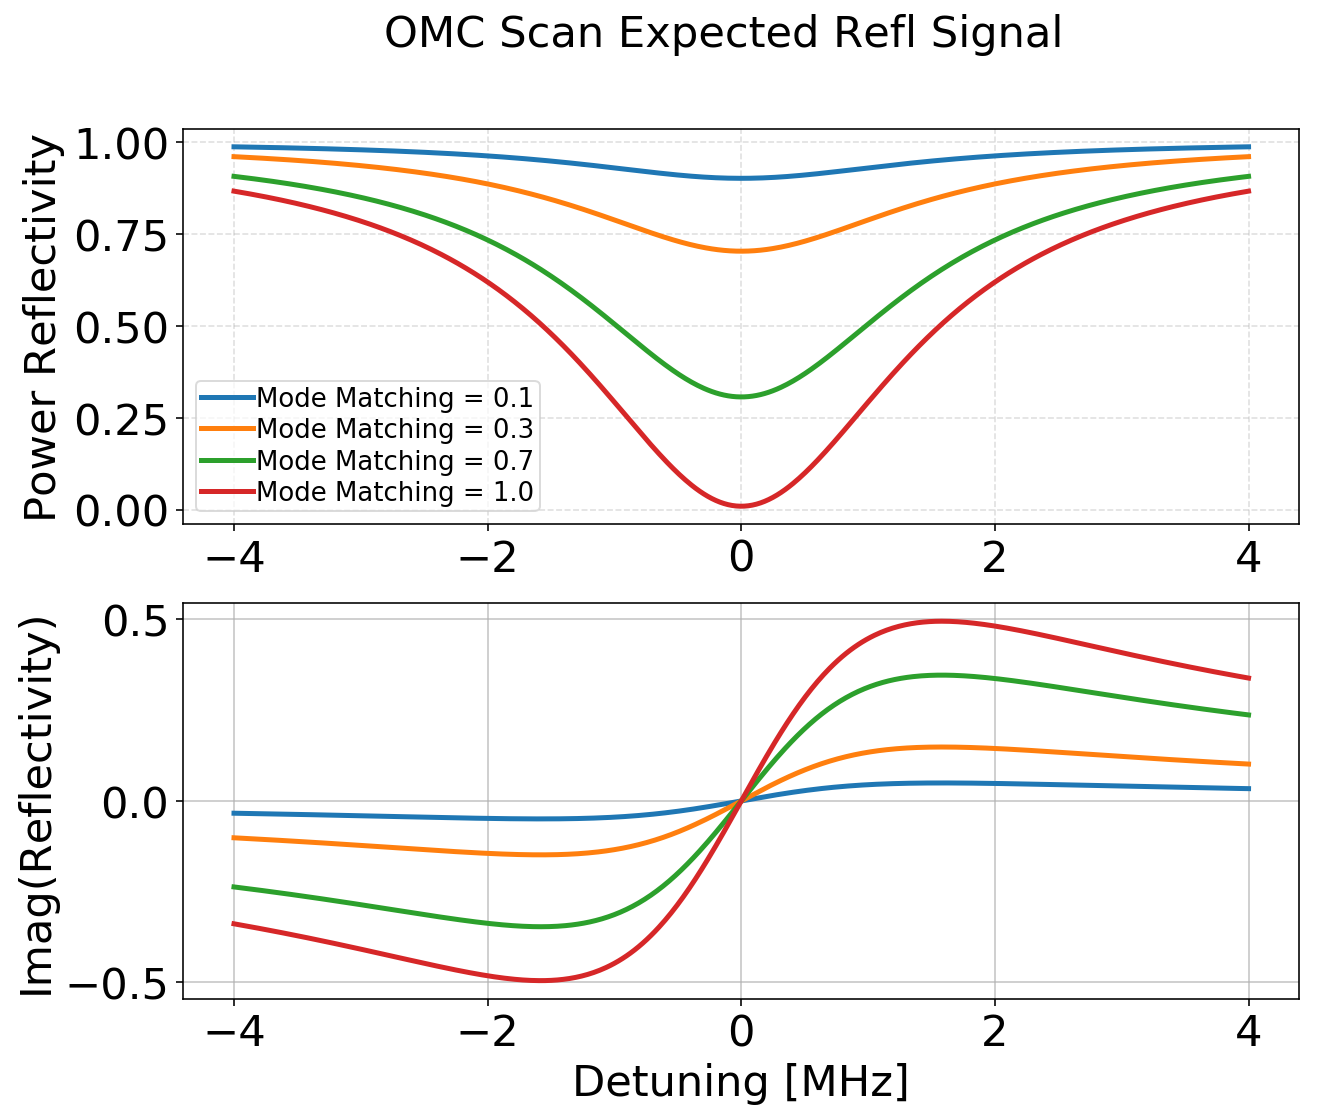

In [274]:
fscan = np.linspace(-4e6,4e6,500)
matches = np.array([0.1,0.3,0.7,1])

fig3, ax3 = plt.subplots(2,1,figsize=(10,8))
for mm in matches:
    Rcavs,iRcavs = Rcav(fscan, match=mm)
    ax3[0].plot(fscan/1e6,Rcavs,label='Mode Matching = {}'.format(mm))
    ax3[1].plot(fscan/1e6,iRcavs,label='Mode Matching = {}'.format(mm))
    
ax3[0].legend(loc='best')
ax3[0].grid('on',which='both', linestyle='--', alpha=0.4)
ax3[1].set_xlabel('Detuning [MHz]')
ax3[0].set_ylabel('Power Reflectivity')
ax3[1].set_ylabel('Imag(Reflectivity)')
ax3[0].set_yticks(np.linspace(0,1,5))
fig3.suptitle('OMC Scan Expected Refl Signal')
fig3.savefig('omcRefl.pdf')